In [1]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
tf.keras.backend.set_session(tf.Session(config=sess_config))

In [2]:
import os
import glob
#import tqdm
import numpy as np
#import pandas as pd
import multiprocessing
import pydicom as dicom
import nibabel as nib
#from keras import utils as kutils
from matplotlib import pyplot as plt

def load_image(label_fpath, transpose=False):
    #encode_name = label_fpath[-39: -7]
    label_data = nib.load(label_fpath)
    label_array = label_data.get_fdata()
    if transpose:
        label_array = np.transpose(label_array, axes=(2, 1, 0))
    return  label_array#, encode_name

In [3]:
cd ../

/home/u/wartytw


In [4]:
import pandas as pd
info = pd.read_csv('/data2/pancreas/Nifti_data/data_list.csv')

info['total'] = [1]*len(info)
pd.DataFrame(info.groupby(['cut', 'type']).sum().total)

total
cut   type          
fine  healthy    102
      tumor       44
thick healthy     82
      tumor      197

In [14]:
import pandas as pd
info = pd.read_csv('/data2/pancreas/Nifti_data/data_list.csv')
image_path = "/data2/pancreas/Nifti_data/image"
label_path = "/data2/pancreas/Nifti_data/label"


shape = np.load("Resection_stage1/shape.npz.npy")
resec = np.load("Resection_stage1/resec.npy")
y = np.load("Resection_stage1/resec_y.npy")
shape_tumor = np.load("Resection_stage1/shape_tumor.npy")

In [6]:
stage = []
size = []
cut = []
for name in resec:
    stage.append(info.iloc[np.where(info.case_id == name)].stage.values[0])
    size.append(info.iloc[np.where(info.case_id == name)]['size'].values[0])
    cut.append(info.iloc[np.where(info.case_id == name)].cut.values[0])

In [6]:

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = stage
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
# inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
# print(inverted)


['IIA' 'IIB' 'III' 'IIB' 'IIB' 'IV' 'IIB' 'III' 'IIB' 'IV' 'IV' 'IV' 'IIB'
 'IV' 'IIA' 'IIB' 'III' 'IIB' 'III' 'IV' 'IIB' 'IV' 'IV' 'IV' 'IIB' 'IIA'
 'IB' 'IV' 'IV' 'IIB' 'IIB' 'III' 'IIB' 'III' 'IIA' 'IIA' 'IV' 'IV' 'IV'
 'IV' 'IV' 'IV' 'III' 'IIB' 'IIB' 'IIB' 'IIA' 'IIB' 'IIA' 'IIA' 'IIB'
 'IIB' 'IV' 'IV' 'IV' 'IV' 'IB' 'IV' 'IIB' 'IIB' 'III' 'IV' 'IIB' 'III'
 'IIB' 'IV' 'IIB' 'IIA' 'IIB' 'IV' 'X' 'IV' 'IIB' 'III' 'IV' 'IV' 'III'
 'IV' 'III' 'IV' 'III' 'IV' 'IIB' 'IV' 'IV' 'IIA' 'IV' 'III' 'III' 'IIA'
 'IIA' 'IIA' 'IIB' 'IV' 'III' 'IV' 'IIA' 'IIB' 'IIB' 'IIA' 'IIB' 'IIB'
 'IV' 'IIB' 'IV' 'IV' 'IV' 'III' 'IV' 'III' 'IIA' 'IIB' 'IV' 'IV' 'I' 'IV'
 'IIB' 'IIB' 'IIB' 'IV' 'IV' 'III' 'IV' 'III' 'III' 'IV' 'IIB' 'IIA' 'IV'
 'III' 'IV' 'IIB' 'IV' 'IIA' 'IIB' 'IB' 'III' 'III' 'IV' 'IV' 'IIB' 'IV'
 'IV' 'IV' 'IV' 'IV' 'III' 'IV' 'IIA' 'IIB' 'III' 'III' 'IIB' 'IV' 'IV'
 'IV' 'IV' 'IV' 'IIA' 'IIB' 'IV' 'IIB' 'IIB' 'IV' 'III' 'IIA' 'IIB' 'IIA'
 'IB' 'II' 'IV' 'IV' 'III' 'IV' 'III' 'III' 'IV' 'IV

/opt/anaconda3/5.2.0/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
print(onehot_encoded.shape)

(182, 8)


In [7]:
import os
tumor_mask_npz_folder = './npz/tumor_mask_images/'

In [8]:
#New
def extract_cube(r, img):#cube 210, 220, 90 ;; ranges = [xmin, xmax, ymin, ymax, zmin, zmax]
    img_tmp = np.zeros((210, 220, 90))
    #print(img.shape, r)
    img_tmp[:int(r[1]-r[0]), :int(r[3]-r[2]), :int(r[5]-r[4])] = img[int(r[0]):int(r[1]), int(r[2]):int(r[3]), int(r[4]):int(r[5])]
    return img_tmp


def masking(label, img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if label[i, j] == 0 or label[i, j] == 1:
                img[i, j] = 0
    return img

import pandas as pd
map_df = pd.DataFrame(data={'resec_name': resec, 'shape': np.array(range(182)), 'target':y.reshape(182)})

In [9]:
from keras.models import Model#, load_model
from keras import layers as klayers
from keras.optimizers import Adam
from keras import utils as kutils
from keras import backend as K
from keras.callbacks import ModelCheckpoint



from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
#from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
#import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py

#init_notebook_mode(connected=True)
%matplotlib inline


from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate,  MaxPool2D
# from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv1D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Reshape
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline



Using TensorFlow backend.


In [29]:
from keras.utils import to_categorical

class resec_Generator1(kutils.Sequence):
    'Generates data for Keras'
    def __init__(self, mapping_df, batch_size, shuffle=True):
        'Initialization'
        self.mapping_df = mapping_df
        self.data_num   = mapping_df.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data_num / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print("enter0")
        batch_mapping_df = \
            self.mapping_df.iloc[index*self.batch_size: (index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(batch_mapping_df)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            self.mapping_df = self.mapping_df.sample(frac=1).reset_index(drop=True)
            
    def __data_generation(self, batch_mapping_df):
        'Generates data containing batch_size samples' 
        # Initialization
        X = np.zeros((  self.batch_size, 210, 220, 90, 1)) 
#         x1 = np.zeros((self.batch_size, 1))
        #x2 = np.zeros((self.batch_size, 8))
        y = np.zeros((self.batch_size))

        # Generate data
        cnt = 0
        
        for i, row in batch_mapping_df.iterrows():
            #img = extract_cube(shape_tumor[row['shape']], load_image(os.path.join(image_path, "IM_"+row['resec_name']+".nii.gz")))
            encode = row['resec_name']
            volume_image = load_image(os.path.join(image_path, "IM_"+encode+".nii.gz"))
            label = load_image(os.path.join(label_path, "LB_"+encode+".nii.gz"))
            volume_image1 = extract_cube(shape_tumor[row['shape'], :], volume_image) 
            label1 = extract_cube(shape_tumor[row['shape'], :], label) 
            num_slice = volume_image1.shape[2]
            for _z in range(0, num_slice):
                label11 = ndimage.binary_dilation(label1[:, :, _z]).astype(label1[:, :, _z].dtype)
                volume_image1[..., _z] = masking(label11, volume_image1[..., _z])
                del label11

            #print(encode)
            X[ cnt, :, :, :, 0] = volume_image1

            #x2[cnt, :] = onehot_encoded[row['shape'], :]
            del volume_image1, label1, volume_image, label
            #img = clip_img(load_image(os.path.join(image_path, "IM_"+row['resec_name']+".nii.gz")))
            #print("resec_name =", row['resec_name'])
#             for j in range(40):
#                 #print("img shape =", img.shape)
#                 #print("j =", j)
#                 X[j][cnt, :, :, :, 0] = extract_cube(img, j)
            y[cnt] = row['target']

#             position = extract_position(row['ref_idx'], row['point_idx'])
#             tmp_cube = extract_cube(position, row['ref_idx'])
#             if (tmp_cube.shape == (19, 19, 19)):
#                 X[cnt, :, :, :, 0] = extract_cube(position, row['ref_idx'])
#             else:
#                 X[cnt, :, :, :, 0] = np.zeros((19, 19, 19))
#             y_idx = row['y_idx']
#             radius = ref[row['ref_idx']][row['point_idx'], 3]
#             y1[cnt, y_idx] = 1
#             y2[cnt, 0] = radius
            cnt += 1
        #print(X[5])
        return X, y

# for name in resec:
#     img = load_image(os.path.join(image_path, "IM_"+name+".nii.gz"))

In [30]:
from keras import metrics
tmp_x = Input((210, 220, 90, 1))
x = Conv3D(filters=32, dilation_rate=1, kernel_size=(3, 3, 3),kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu')(tmp_x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPool3D()(x)

x = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3),kernel_initializer =keras.initializers.he_normal(seed=None), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPool3D()(x)

x = Conv3D(filters=8, dilation_rate=1, kernel_size=(3, 3, 3),kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool3D()(x)



x = Conv3D(filters=4, dilation_rate=1, kernel_size=(3, 3, 3),kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool3D()(x)


x = Flatten()(x)
x = Dense(units=500, kernel_initializer='normal', activation='elu')(x)
x = Dense(units=100,kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu')(x)
x = Dense(units=5, activation='relu')(x)


# tmp_a = Input((1,))
# a = Dense(5, activation='elu')(tmp_a)
# a = Dense(2, kernel_initializer =keras.initializers.he_normal(seed=None),activation='relu')(a)
# a = Dense(1,kernel_initializer =  keras.initializers.he_normal(seed=None) , activation='sigmoid')(a)

# tmp_b = Input((8,))
# b = Dense(10, activation='selu')(tmp_b)
# b = Dense(20, activation='selu')(b)
# b = Dense(10, activation='elu')(b)
# b = Dense(5, activation='relu' )(b)
# b = Dense(1, activation='sigmoid')(b)

#x = concatenate([x, a, b], axis = 1)
# x = concatenate([x, a], axis = 1)
x = Dense(1, kernel_initializer =  keras.initializers.he_normal(seed=None),activation='sigmoid')(x)




model = Model(inputs=tmp_x, outputs=x)
#model = Model(inputs=[tmp_x, tmp_a, tmp_b], outputs=x)
adam_lr = 0.0002
adam_beta_1 = 0.5
model.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
              loss='binary_crossentropy', metrics = [metrics.binary_accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 210, 220, 90, 1)   0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 208, 218, 88, 32)  896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 208, 218, 88, 32)  128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 208, 218, 88, 32)  0         
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 104, 109, 44, 32)  0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 102, 107, 42, 16)  13840     
_________________________________________________________________
batch_normalization_15 (Batc (None, 102, 107, 42, 16)  64        
__________

In [31]:
batch_size = 1
v_generator = resec_Generator1(map_df[:-50], batch_size=batch_size)
validation_generator = resec_Generator1(map_df[-50:-30], batch_size=batch_size)

In [32]:
from scipy import ndimage
history = model.fit_generator(v_generator,
                              epochs=100, validation_data=validation_generator)

Epoch 1/100
132/132 [==============================] - 580s 4s/step - loss: 0.6932 - binary_accuracy: 0.4848 - val_loss: 0.6930 - val_binary_accuracy: 0.6000
Epoch 2/100
132/132 [==============================] - 520s 4s/step - loss: 0.6932 - binary_accuracy: 0.5000 - val_loss: 0.6929 - val_binary_accuracy: 0.6000
Epoch 3/100
132/132 [==============================] - 547s 4s/step - loss: 0.6931 - binary_accuracy: 0.5227 - val_loss: 0.6928 - val_binary_accuracy: 0.6000
Epoch 4/100
132/132 [==============================] - 527s 4s/step - loss: 0.6931 - binary_accuracy: 0.5227 - val_loss: 0.6927 - val_binary_accuracy: 0.6000
Epoch 5/100
132/132 [==============================] - 538s 4s/step - loss: 0.6931 - binary_accuracy: 0.5227 - val_loss: 0.6926 - val_binary_accuracy: 0.6000
Epoch 6/100
132/132 [==============================] - 520s 4s/step - loss: 0.6931 - binary_accuracy: 0.5227 - val_loss: 0.6925 - val_binary_accuracy: 0.6000
Epoch 7/100
132/132 [==============================]

KeyboardInterrupt: 

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


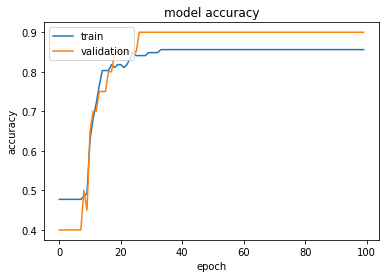

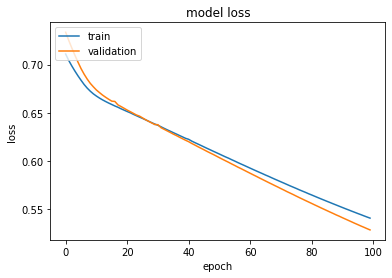

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [40]:
from scipy import ndimage
history2 = model.fit_generator(v_generator,
                              epochs=10, validation_data=validation_generator)

Epoch 1/10
132/132 [==============================] - 588s 4s/step - loss: 6.9707 - binary_accuracy: 0.4015 - val_loss: 7.4297 - val_binary_accuracy: 0.2500
Epoch 2/10
132/132 [==============================] - 531s 4s/step - loss: 6.4780 - binary_accuracy: 0.4167 - val_loss: 7.4293 - val_binary_accuracy: 0.2000
Epoch 3/10
132/132 [==============================] - 515s 4s/step - loss: 6.4756 - binary_accuracy: 0.4091 - val_loss: 7.4288 - val_binary_accuracy: 0.2000
Epoch 4/10
132/132 [==============================] - 547s 4s/step - loss: 6.4732 - binary_accuracy: 0.4091 - val_loss: 7.4283 - val_binary_accuracy: 0.2000
Epoch 5/10
132/132 [==============================] - 544s 4s/step - loss: 6.4711 - binary_accuracy: 0.4091 - val_loss: 7.4278 - val_binary_accuracy: 0.2000
Epoch 6/10
132/132 [==============================] - 536s 4s/step - loss: 6.4689 - binary_accuracy: 0.4091 - val_loss: 7.4273 - val_binary_accuracy: 0.2000
Epoch 7/10
132/132 [==============================] - 544s

In [44]:
from scipy import ndimage
history3 = model.fit_generator(v_generator,
                              epochs=10, validation_data=validation_generator)

Epoch 1/10
132/132 [==============================] - 569s 4s/step - loss: 0.7057 - binary_accuracy: 0.5227 - val_loss: 0.6633 - val_binary_accuracy: 0.6000
Epoch 2/10
132/132 [==============================] - 543s 4s/step - loss: 0.6935 - binary_accuracy: 0.5227 - val_loss: 0.6544 - val_binary_accuracy: 0.6000
Epoch 3/10
132/132 [==============================] - 534s 4s/step - loss: 0.6825 - binary_accuracy: 0.5227 - val_loss: 0.6460 - val_binary_accuracy: 0.6000
Epoch 4/10
132/132 [==============================] - 543s 4s/step - loss: 0.6731 - binary_accuracy: 0.5227 - val_loss: 0.6381 - val_binary_accuracy: 0.6000
Epoch 5/10
132/132 [==============================] - 525s 4s/step - loss: 0.6648 - binary_accuracy: 0.5227 - val_loss: 0.6305 - val_binary_accuracy: 0.6000
Epoch 6/10
132/132 [==============================] - 555s 4s/step - loss: 0.6573 - binary_accuracy: 0.5227 - val_loss: 0.6233 - val_binary_accuracy: 0.6000
Epoch 7/10
132/132 [==============================] - 530s

In [46]:
# from scipy import ndimage
# history4 = model.fit_generator(v_generator,
#                               epochs=10, validation_data=validation_generator)

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


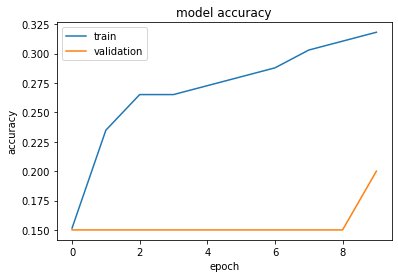

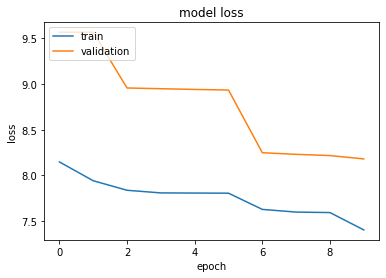

In [47]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


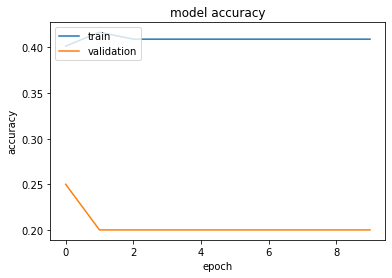

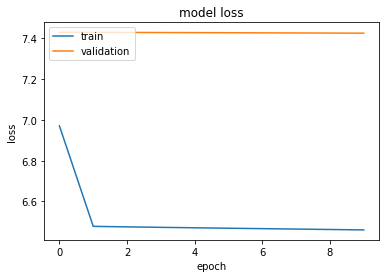

In [48]:
# list all data in history
history = history2
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


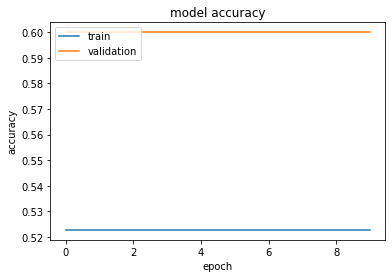

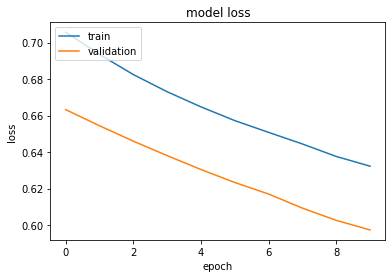

In [49]:
# list all data in history
history = history3
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()